<a href="https://colab.research.google.com/github/jathusharini/intrusion-detection-fewshot-vs-traditional/blob/main/few-shot-learning/few_shot_learning_model_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Required Libraries
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE  # If needed for SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np


In [2]:
# Preprocessing Function
def preprocess_binary_csv(csv_path, n_support, n_query):
    """
    Preprocess CSV data into support and query sets for binary classification.
    """
    df = pd.read_csv(csv_path)

    # Clean column names (remove extra spaces if any)
    df.columns = df.columns.str.strip()

    # Ensure all features are numeric and handle missing data
    feature_columns = df.columns.difference(['Label', 'Attack Type'])
    df[feature_columns] = df[feature_columns].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=feature_columns)

    # Separate the two classes: attack (1) and normal (0)
    attack_data = df[df["Label"] == 1]
    normal_data = df[df["Label"] == 0]

    print(f"Attack Samples: {len(attack_data)}")
    print(f"Normal Samples: {len(normal_data)}")

    # Ensure enough samples for support and query sets
    if len(attack_data) < n_support + n_query or len(normal_data) < n_support + n_query:
        raise ValueError("Not enough samples in one or more classes to split into support and query sets.")

    # Split each class into support and query sets
    attack_support, attack_query = train_test_split(attack_data, test_size=0.6, random_state=42)
    normal_support, normal_query = train_test_split(normal_data, test_size=0.6, random_state=42)

    # Select support and query samples
    attack_support = attack_support[:n_support]
    normal_support = normal_support[:n_support]
    attack_query = attack_query[:n_query]
    normal_query = normal_query[:n_query]

    # Combine the support and query sets
    support_set = pd.concat([attack_support, normal_support])
    query_set = pd.concat([attack_query, normal_query])

    # Convert to PyTorch tensors
    support_x = torch.tensor(support_set[feature_columns].values, dtype=torch.float32)
    support_y = torch.tensor(support_set["Label"].values, dtype=torch.int64)
    query_x = torch.tensor(query_set[feature_columns].values, dtype=torch.float32)
    query_y = torch.tensor(query_set["Label"].values, dtype=torch.int64)

    return support_x, support_y, query_x, query_y

In [3]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

def preprocess_and_oversample(csv_path, n_support, n_query):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    # Separate features and labels
    feature_columns = df.columns.difference(['Label'])
    X = df[feature_columns]
    y = df['Label']

    # Ensure all features are numeric
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Oversample
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)

    # Split into support and query sets
    from sklearn.model_selection import train_test_split
    support_x, query_x, support_y, query_y = train_test_split(
        X_resampled, y_resampled, test_size=n_query / len(X_resampled), stratify=y_resampled, random_state=42
    )

    # Convert to PyTorch tensors
    return torch.tensor(support_x, dtype=torch.float32), \
           torch.tensor(support_y.to_numpy(), dtype=torch.int64), \
           torch.tensor(query_x, dtype=torch.float32), \
           torch.tensor(query_y.to_numpy(), dtype=torch.int64)


In [4]:
class ProtoNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim, dropout_rate=0.5):
        super(ProtoNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Batch normalization
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.fc2 = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))  # Batch norm and activation
        x = self.dropout(x)  # Dropout
        x = self.fc2(x)
        return x

    def compute_prototypes(self, support_embed, support_y):
        unique_labels = torch.unique(support_y)
        prototypes = []
        for label in unique_labels:
            class_embed = support_embed[support_y == label]
            prototypes.append(class_embed.mean(dim=0))
        return torch.stack(prototypes)

    def compute_distances(self, query_embed, prototypes, metric='cosine'):
        if metric == 'cosine':
            query_embed = nn.functional.normalize(query_embed, dim=1)
            prototypes = nn.functional.normalize(prototypes, dim=1)
            distances = 1 - torch.matmul(query_embed, prototypes.T)
        else:
            distances = torch.cdist(query_embed, prototypes)
        return distances

    def set_forward_loss(self, support_x, support_y, query_x, query_y, lambda_reg=0.1):
        support_embed = self.forward(support_x)
        query_embed = self.forward(query_x)

        prototypes = self.compute_prototypes(support_embed, support_y)
        distances = self.compute_distances(query_embed, prototypes)

        class_counts = torch.bincount(support_y)
        total_samples = len(support_y)
        class_weights = total_samples / (len(class_counts) * class_counts)
        class_weights = class_weights.to(distances.device)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fn(distances, query_y)

        proto_distances = torch.cdist(prototypes, prototypes)
        reg_loss = lambda_reg * (1 / (proto_distances + 1e-5)).sum()

        total_loss = loss + reg_loss
        accuracy = (distances.argmax(dim=1) == query_y).float().mean()
        return total_loss, accuracy


In [12]:
def train_with_diagnostics(
    model, optimizer, train_x, train_y, val_x, val_y, test_x, test_y,
    criterion, n_epochs=50, patience=10, batch_size=32
):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []
    best_val_loss = float("inf")
    best_model_weights = None
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        epoch_loss, correct_predictions = 0.0, 0
        num_batches = (len(train_x) + batch_size - 1) // batch_size

        # Training loop
        for i in range(num_batches):
            batch_x = train_x[i * batch_size : (i + 1) * batch_size].to(device)
            batch_y = train_y[i * batch_size : (i + 1) * batch_size].to(device)

            optimizer.zero_grad()
            batch_embeddings = model(batch_x)
            prototypes = model.compute_prototypes(model.forward(train_x), train_y)
            distances = model.compute_distances(batch_embeddings, prototypes, metric='cosine')

            loss = criterion(-distances, batch_y)  # CrossEntropy expects logits
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            predictions = distances.argmax(dim=1)
            correct_predictions += (predictions == batch_y).sum().item()

        train_loss = epoch_loss / num_batches
        train_acc = correct_predictions / len(train_x)

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_embeddings = model(val_x.to(device))
            val_prototypes = model.compute_prototypes(model.forward(train_x), train_y)
            val_distances = model.compute_distances(val_embeddings, val_prototypes, metric='cosine')
            val_loss = criterion(-val_distances, val_y.to(device)).item()
            val_predictions = val_distances.argmax(dim=1)
            val_acc = (val_predictions == val_y.to(device)).float().mean().item()

        # Save history
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        print(
            f"Epoch {epoch+1}/{n_epochs} -- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Restore best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history


In [10]:
def plot_training_history(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, query_x, query_y):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    query_x, query_y = query_x.to(device), query_y.to(device)

    with torch.no_grad():
        query_embed = model(query_x)
        support_embed = model(query_x)  # Reuse query as dummy for prototypes
        prototypes = model.compute_prototypes(support_embed, query_y)
        distances = model.compute_distances(query_embed, prototypes)
        predictions = distances.argmin(dim=1)

    cm = confusion_matrix(query_y.cpu().numpy(), predictions.cpu().numpy())
    disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Attack"])
    disp.plot()
    return predictions


Epoch 1/50 -- Train Loss: 0.6617, Train Acc: 0.3261, Val Loss: 0.6532, Val Acc: 0.3400
Epoch 2/50 -- Train Loss: 0.6498, Train Acc: 0.2913, Val Loss: 0.6387, Val Acc: 0.2400
Epoch 3/50 -- Train Loss: 0.6379, Train Acc: 0.2826, Val Loss: 0.6200, Val Acc: 0.2200
Epoch 4/50 -- Train Loss: 0.6197, Train Acc: 0.2522, Val Loss: 0.5972, Val Acc: 0.1600
Epoch 5/50 -- Train Loss: 0.6017, Train Acc: 0.2652, Val Loss: 0.5698, Val Acc: 0.1400
Epoch 6/50 -- Train Loss: 0.5870, Train Acc: 0.2478, Val Loss: 0.5399, Val Acc: 0.1400
Epoch 7/50 -- Train Loss: 0.5512, Train Acc: 0.1913, Val Loss: 0.5086, Val Acc: 0.1400
Epoch 8/50 -- Train Loss: 0.5381, Train Acc: 0.2000, Val Loss: 0.4778, Val Acc: 0.1400
Epoch 9/50 -- Train Loss: 0.5005, Train Acc: 0.1826, Val Loss: 0.4488, Val Acc: 0.1400
Epoch 10/50 -- Train Loss: 0.4937, Train Acc: 0.2130, Val Loss: 0.4242, Val Acc: 0.1800
Epoch 11/50 -- Train Loss: 0.4836, Train Acc: 0.1870, Val Loss: 0.4036, Val Acc: 0.1400
Epoch 12/50 -- Train Loss: 0.4605, Train 

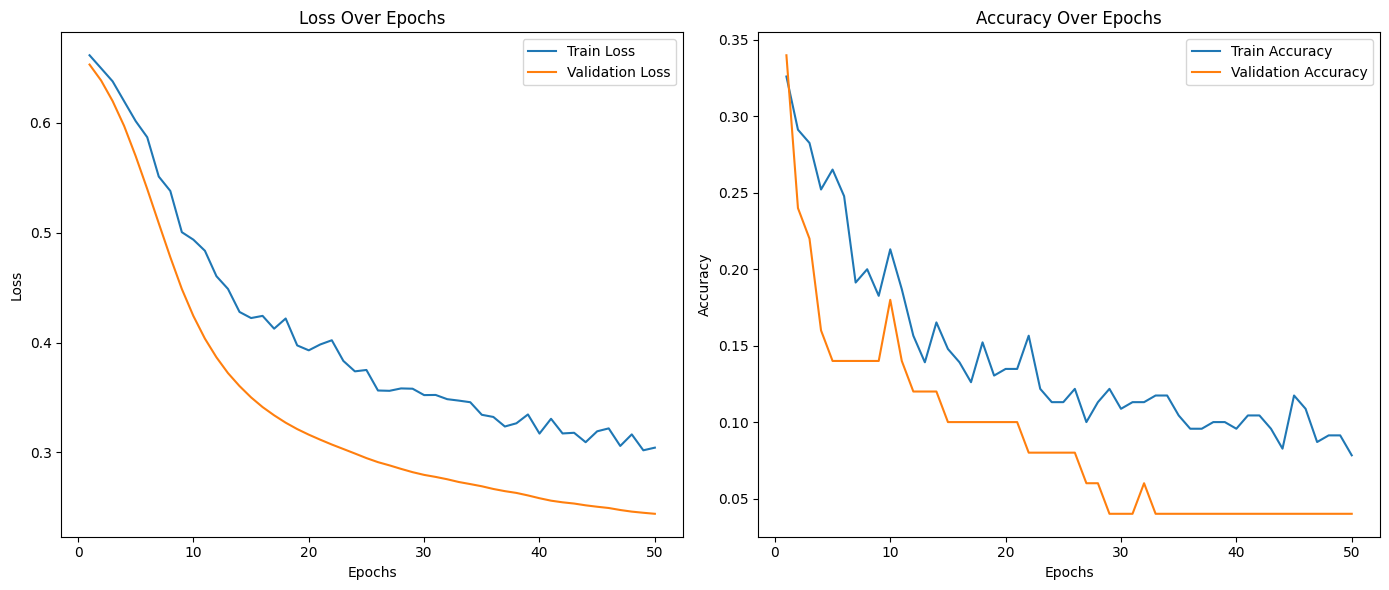

Test Accuracy: 96.00%
Precision: 0.9259, Recall: 1.0000, F1-Score: 0.9615


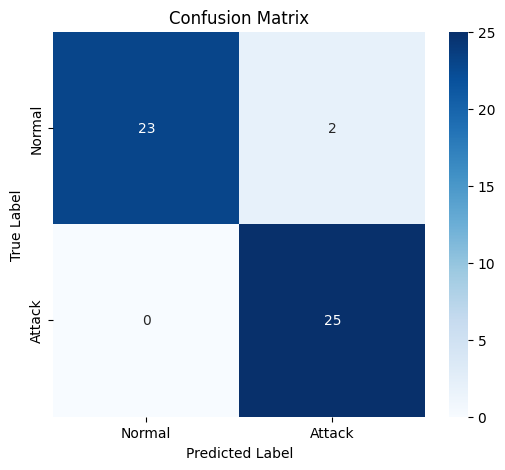

In [14]:
if __name__ == "__main__":

    # File paths and hyperparameters
    csv_path = "/content/cleaned_dataset.csv"
    n_support = 30
    n_query = 50
    max_epoch = 50
    epoch_size = 200
    learning_rate = 1e-4
    weight_decay = 0.001

    # Device setup
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    # Preprocessing the dataset
    support_x, support_y, query_x, query_y = preprocess_and_oversample(csv_path, n_support, n_query)

    # Initialize ProtoNet model
    model = ProtoNet(
        input_dim=support_x.shape[1],
        hidden_dim=128,
        z_dim=64,
        dropout_rate=0.4
    ).to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training the model
    history = train_with_diagnostics(
        model, optimizer,
        train_x=support_x, train_y=support_y,
        val_x=query_x, val_y=query_y,
        test_x=query_x, test_y=query_y,
        criterion=torch.nn.CrossEntropyLoss(),
        n_epochs=max_epoch,
        patience=10,
        batch_size=32
    )

    # Save the final model
    torch.save(model.state_dict(), "protonet_final_model.pth")

    # Extract history and plot training diagnostics
    train_loss, val_loss, train_acc, val_acc = history
    plot_training_history(train_loss, val_loss, train_acc, val_acc)

    # Evaluate the model on the query set
    model.eval()
    with torch.no_grad():
        query_embed = model(query_x.to(device))
        prototypes = model.compute_prototypes(model.forward(support_x.to(device)), support_y.to(device))
        distances = model.compute_distances(query_embed, prototypes, metric='cosine')
        predictions = distances.argmin(dim=1)

        test_accuracy = (predictions == query_y.to(device)).float().mean().item()
        precision = precision_score(query_y.cpu(), predictions.cpu(), zero_division=1)
        recall = recall_score(query_y.cpu(), predictions.cpu(), zero_division=1)
        f1 = f1_score(query_y.cpu(), predictions.cpu(), zero_division=1)

    # Display final results
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(query_y.cpu(), predictions.cpu())
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Normal", "Attack"],
        yticklabels=["Normal", "Attack"]
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
